In [4]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
df = pd.read_csv('vio.csv')
df.head()

,camis,inspection_date,grade,score,critical,not_applicable,not_critical,02A,02B,02C,...,20B,20D,20E,20F,22A,22B,22C,22E,22F,22G
0,30075445,2/18/2016,A,10,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30075445,5/11/2018,A,5,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30075445,5/18/2017,A,7,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30112340,3/4/2019,A,13,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30112340,3/13/2018,A,12,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_train = pd.read_csv('clean_inspection.csv')
df_train.head(3)

/Users/aliceliu/anaconda/envs/myenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,VIOLATION CODE,VIOLATION DESCRIPTION,CRITICAL FLAG,SCORE,GRADE,GRADE DATE,RECORD DATE,INSPECTION TYPE
0,0,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,05/11/2018,Violations were cited in the following area(s).,08C,Pesticide use not in accordance with label or ...,Not Critical,5.0,A,05/11/2018,04/23/2019,Cycle Inspection / Initial Inspection
1,1,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,05/11/2018,Violations were cited in the following area(s).,10F,Non-food contact surface improperly constructe...,Not Critical,5.0,A,05/11/2018,04/23/2019,Cycle Inspection / Initial Inspection
2,2,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,7188924968,Bakery,05/18/2017,Violations were cited in the following area(s).,06D,"Food contact surface not properly washed, rins...",Critical,7.0,A,05/18/2017,04/23/2019,Cycle Inspection / Initial Inspection


In [7]:
def level_code(row):
    if type(row) == float: return 99, 'No'
    return int(row[:2]), row[2]
df_train['VIO_lvl'],df_train['VIO_type'] = zip(*df_train['VIOLATION CODE'].apply(lambda row: level_code(row)))
#df_train['RECORD_DATE'] = pd.to_datetime(df_train['RECORD DATE'], format = '%m/%d/%Y', errors='coerce')
df_train['INSPECTION_DATE'] = pd.to_datetime(df_train['INSPECTION DATE'], format = '%m/%d/%Y', errors='coerce')
df_train['GRADE_DATE'] = pd.to_datetime(df_train['GRADE DATE'], format = '%m/%d/%Y', errors='coerce')
df_train.drop(['RECORD DATE', 'INSPECTION DATE', 'GRADE DATE'], axis = 1, inplace = True)

df_train.columns = ['_'.join(x.lower().split()) for x in df_train.columns]


In [8]:
tmp_tab = pd.crosstab(df_train['action'], df_train['grade'])
tmp_tab[['A', 'B', 'C']]

grade,A,B,C
action,,,
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.,141,352,12779
Establishment re-closed by DOHMH,467,401,376
Establishment re-opened by DOHMH,934,35,0
No violations were recorded at the time of this inspection.,1087,4,4
Violations were cited in the following area(s).,169168,109587,60031


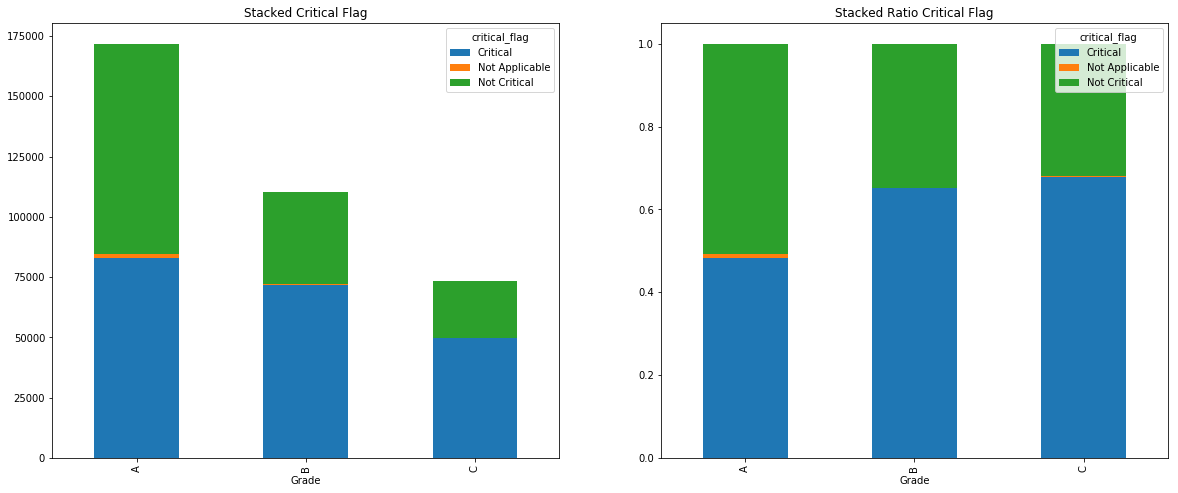

In [10]:
f = plt.figure(figsize = (20,8))
ax = f.add_subplot(1,2,1)
tmp_tab = pd.crosstab(df_train['critical_flag'], df_train['grade'])
tmp_crit = tmp_tab[['A', 'B', 'C']].T
tmp_crit.plot.bar(stacked = True, ax = ax)
ax.set_title('Stacked Critical Flag')
ax.set_xlabel('Grade')

sum_ = tmp_crit.sum(axis = 1)
for col in tmp_crit.columns:
    tmp_crit[col] = tmp_crit[col].divide(sum_)
ax = f.add_subplot(1,2,2)
tmp_crit.plot.bar(stacked = True, ax = ax)
ax.set_title('Stacked Ratio Critical Flag')
ax.set_xlabel('Grade')

plt.show()


Grade B and C, comparing with grade A, have higher crtical ratio. Obviously, there are more grade A than the other grades.

/nfshome/ql459/.conda/envs/myEnv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


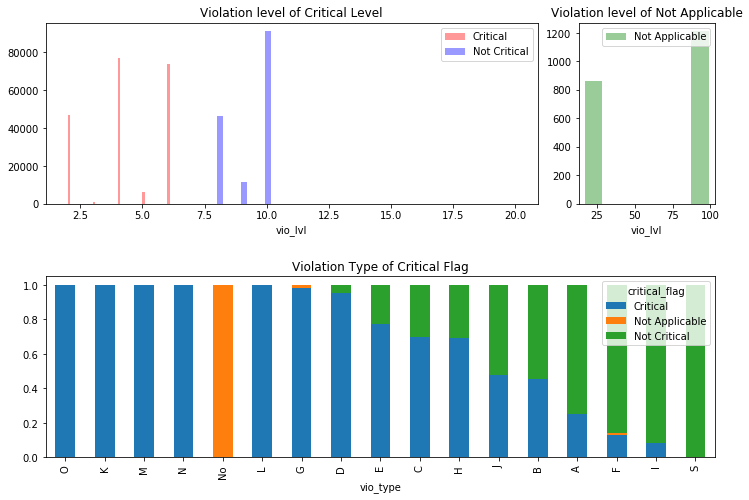

In [41]:
f = plt.figure(figsize = (12,8))
ax = plt.subplot2grid((2,4), (0,0), colspan = 3)
sns.distplot(df_train.vio_lvl.loc[df_train.critical_flag == 'Critical'], ax = ax, kde = False, color = 'r', label = 'Critical')
sns.distplot(df_train.vio_lvl.loc[df_train.critical_flag == 'Not Critical'], ax = ax, kde = False, color = 'b', label = 'Not Critical')
ax.set_title('Violation level of Critical Level')
ax.legend()
ax = plt.subplot2grid((2,4), (0,3))
sns.distplot(df_train.vio_lvl.loc[df_train.critical_flag == 'Not Applicable'], ax = ax, kde = False, color = 'g', label = 'Not Applicable')
ax.set_title('Violation level of Not Applicable')
ax.legend()

ax = plt.subplot2grid((2,4), (1,0), colspan = 4)
tmp_type = df_train[['critical_flag', 'vio_type']].groupby(['critical_flag', 'vio_type']).size().to_frame().reset_index()
tmp_type = tmp_type.pivot('critical_flag', 'vio_type').fillna(0)
tmp_type.columns = tmp_type.columns.droplevel(0)
tmp_type = tmp_type.T
sum_type = tmp_type.sum(axis = 1)
for col in tmp_type.columns:
    tmp_type[col] = tmp_type[col].divide(sum_type)
tmp_type.sort_values('Not Critical').plot.bar(stacked = True, ax = ax)
ax.set_title('Violation Type of Critical Flag')

plt.subplots_adjust(wspace = 0.3, hspace = 0.4)
plt.show()

Through the graph above, we could see that violation type do have affects to the crtical flag.
Through our violation level of critcal level, for violation level which is under 7 means it "Critical". The graph "Violation type of critical flag" shows that violation types O, K, M, N, L, G, D shows more crtical symptons during the inspection test. For "Not applicable" under the critical flag, there are mostly at violation level 100 and under violation number No with tiny distirbution in type G and F.